# 8. How to Implement Linear Regression

In the previous lesson, we calculated the least squares linear regression for a diabetes dataset, using scikit learn's implementation.  Today, we will look at how we could write our own implementation.

## Getting set up

In [48]:
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math, scipy, numpy as np
from scipy import linalg

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.set_printoptions(precision=6)

In [3]:
data = datasets.load_diabetes()

In [4]:
feature_names=['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [5]:
trn,test,y_trn,y_test = train_test_split(data.data, data.target, test_size=0.2)

In [6]:
trn.shape, test.shape

((353, 10), (89, 10))

In [7]:
def regr_metrics(act, pred):
    return (math.sqrt(metrics.mean_squared_error(act, pred)), 
     metrics.mean_absolute_error(act, pred))

### How did sklearn do it?

How is sklearn doing this?  By checking [the source code](https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/linear_model/base.py#L417), you can see that in the dense case, it calls [scipy.linalg.lstqr](https://github.com/scipy/scipy/blob/v0.19.0/scipy/linalg/basic.py#L892-L1058), which is calling a LAPACK method:

        Options are ``'gelsd'``, ``'gelsy'``, ``'gelss'``. Default
        (``'gelsd'``) is a good choice.  However, ``'gelsy'`` can be slightly
        faster on many problems.  ``'gelss'`` was used historically.  It is
        generally slow but uses less memory.

- [gelsd](https://software.intel.com/sites/products/documentation/doclib/mkl_sa/11/mkl_lapack_examples/_gelsd.htm): uses SVD and a divide-and-conquer method
- [gelsy](https://software.intel.com/en-us/node/521113): uses QR factorization
- [gelss](https://software.intel.com/en-us/node/521114): uses SVD

#### Scipy Sparse Least Squares

We will not get into too much detail about the sparse version of least squares.  Here is a bit of info if you are interested: 

[Scipy sparse lsqr](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsqr.html#id1) uses an iterative method called [Golub and Kahan bidiagonalization](https://web.stanford.edu/class/cme324/paige-saunders2.pdf).

from [scipy sparse lsqr source code](https://github.com/scipy/scipy/blob/v0.14.0/scipy/sparse/linalg/isolve/lsqr.py#L96):
  Preconditioning is another way to reduce the number of iterations. If it is possible to solve a related system ``M*x = b`` efficiently, where M approximates A in some helpful way (e.g. M - A has low rank or its elements are small relative to those of A), LSQR may converge more rapidly on the system ``A*M(inverse)*z = b``, after which x can be recovered by solving M\*x = z.
  
If A is symmetric, LSQR should not be used! Alternatives are the symmetric conjugate-gradient method (cg) and/or SYMMLQ.  SYMMLQ is an implementation of symmetric cg that applies to any symmetric A and will converge more rapidly than LSQR.  If A is positive definite, there are other implementations of symmetric cg that require slightly less work per iteration than SYMMLQ (but will take the same number of iterations).

### linalg.lstqr

The sklearn implementation handled adding a constant term (since the y-intercept is presumably not 0 for the line we are learning) for us.  We will need to do that by hand now:

In [8]:
trn_int = np.c_[trn, np.ones(trn.shape[0])]
test_int = np.c_[test, np.ones(test.shape[0])]

Since `linalg.lstsq` lets us specify which LAPACK routine we want to use, lets try them all and do some timing comparisons:

In [9]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelsd")

756 µs ± 373 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelsy")

396 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelss")

539 µs ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Naive Solution

Recall that we want to find $\hat{x}$ that minimizes: 
$$ \big\vert\big\vert Ax - b \big\vert\big\vert_2$$

Another way to think about this is that we are interested in where vector $b$ is closest to the subspace spanned by $A$ (called the *range of* $A$).  This is the projection of $b$ onto $A$.  Since $b - A\hat{x}$ must be perpendicular to the subspace spanned by $A$, we see that

$$A^T (b - A\hat{x}) = 0 $$

(we are using $A^T$ because we want to multiply each column of $A$ by $b - A\hat{x}$

This leads us to the *normal equations*:
$$ x = (A^TA)^{-1}A^T b $$

In [12]:
def ls_naive(A, b):
     return np.linalg.inv(A.T @ A) @ A.T @ b

In [13]:
%timeit coeffs_naive = ls_naive(trn_int, y_trn)

242 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
coeffs_naive = ls_naive(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_naive)

(54.74112841224639, 43.616259517733866)

## Normal Equations (Cholesky)

Normal equations:
$$ A^TA x = A^T b $$

If $A$ has full rank, the pseudo-inverse $(A^TA)^{-1}A^T$ is a **square, hermitian positive definite** matrix.  The standard way of solving such a system is *Cholesky Factorization*, which finds upper-triangular R s.t. $A^TA = R^TR$.

The following steps are based on Algorithm 11.1 from Trefethen:

In [15]:
A = trn_int

In [16]:
b = y_trn

In [17]:
AtA = A.T @ A
Atb = A.T @ b

**Warning:** Numpy and Scipy default to different upper/lower for Cholesky

In [18]:
R = scipy.linalg.cholesky(AtA)

In [19]:
np.set_printoptions(suppress=True, precision=4)
R

array([[ 0.9053,  0.1572,  0.1937,  0.2909,  0.2386,  0.2153, -0.0972,
         0.2129,  0.2487,  0.3066, -0.0036],
       [ 0.    ,  0.879 ,  0.026 ,  0.157 , -0.0053,  0.0903, -0.3403,
         0.2857,  0.1116,  0.153 , -0.2508],
       [ 0.    ,  0.    ,  0.9084,  0.3227,  0.1877,  0.1932, -0.3021,
         0.3348,  0.3685,  0.2778,  0.6207],
       [ 0.    ,  0.    ,  0.    ,  0.7823,  0.1272,  0.0602,  0.0452,
         0.0253,  0.1552,  0.1602,  0.2867],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.8319,  0.7652,  0.1247,
         0.404 ,  0.3111,  0.1517, -1.3514],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.3586, -0.4493,
         0.2981, -0.3035, -0.0371,  0.9871],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.5983,
        -0.4969, -0.5296, -0.2066,  0.5326],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.3021, -0.0347,  0.0345,  0.0813],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
 

check our factorization:

In [20]:
np.linalg.norm(AtA - R.T @ R)

1.7053167055689525e-13

$$ A^T A x = A^T b $$
$$ R^T R x = A^T b $$
$$ R^T w = A^T b $$
$$ R x = w $$

In [21]:
w = scipy.linalg.solve_triangular(R, Atb, lower=False, trans='T')

It's always good to check that our result is what we expect it to be: (in case we entered the wrong params, the function didn't return what we thought, or sometimes the docs are even outdated)

In [22]:
np.linalg.norm(R.T @ w - Atb)

7.276901242564163e-12

In [23]:
coeffs_chol = scipy.linalg.solve_triangular(R, w, lower=False)

In [24]:
np.linalg.norm(R @ coeffs_chol - w)

1.3163706111620333e-13

In [25]:
def ls_chol(A, b):
    R = scipy.linalg.cholesky(A.T @ A)
    w = scipy.linalg.solve_triangular(R, A.T @ b, trans='T')
    return scipy.linalg.solve_triangular(R, w)

In [26]:
%timeit coeffs_chol = ls_chol(trn_int, y_trn)

426 µs ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
coeffs_chol = ls_chol(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_chol)

(54.74112841224633, 43.61625951773386)

## QR Factorization

$$ A x = b $$
$$ A = Q R $$
$$ Q R x = b $$

$$ R x = Q^T b $$

In [28]:
def ls_qr(A,b):
    Q, R = scipy.linalg.qr(A, mode='economic')
    return scipy.linalg.solve_triangular(R, Q.T @ b)

In [29]:
%timeit coeffs_qr = ls_qr(trn_int, y_trn)

573 µs ± 9.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
coeffs_qr = ls_qr(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_qr)

(54.74112841224633, 43.61625951773383)

## SVD

$$ A x = b $$

$$ A = U \Sigma V $$

$$ \Sigma V x = U^T b $$

$$ \Sigma w = U^T b $$

$$ x = V^T w $$

SVD gives the pseudo-inverse

In [31]:
def ls_svd(A,b):
    m, n = A.shape
    U, sigma, Vh = scipy.linalg.svd(A, full_matrices=False)
    w = (U.T @ b)/ sigma
    return Vh.T @ w

In [32]:
%timeit coeffs_svd = ls_svd(trn_int, y_trn)

483 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
%timeit coeffs_svd = ls_svd(trn_int, y_trn)

509 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
coeffs_svd = ls_svd(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_svd)

(54.74112841224697, 43.61625951773435)

## Random Sketching Technique for Least Squares Regression

[Linear Sketching](http://researcher.watson.ibm.com/researcher/files/us-dpwoodru/journal.pdf) (Woodruff)

1. Sample a r x n random matrix S, r << n
2. Compute S A and S b
3. Find exact solution x to regression SA x = Sb

## Timing Comparison

In [35]:
import timeit
import pandas as pd

In [36]:
def scipylstq(A, b):
    return scipy.linalg.lstsq(A,b)[0]

In [37]:
row_names = ['Normal Eqns- Naive',
             'Normal Eqns- Cholesky', 
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'Normal Eqns- Cholesky': 'ls_chol', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [38]:
m_array = np.array([100, 1000, 10000])
n_array = np.array([20, 100, 1000])

In [39]:
index = pd.MultiIndex.from_product([m_array, n_array], names=['# rows', '# cols'])

In [40]:
pd.options.display.float_format = '{:,.6f}'.format
df = pd.DataFrame(index=row_names, columns=index)
df_error = pd.DataFrame(index=row_names, columns=index)

In [43]:
# %%prun   df.set_value(i, 'score', score)    df.loc[i, 'score'] = score
for m in m_array:
    for n in n_array:
        if m >= n:        
            x = np.random.uniform(-10,10,n)
            A = np.random.uniform(-40,40,[m,n])   # removed np.asfortranarray
            b = np.matmul(A, x) + np.random.normal(0,2,m)
            for name in row_names:
                fcn = name2func[name]
                t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
                df.loc[name, (m,n)] = t #df.set_value(name, (m,n), t)
                coeffs = locals()[fcn](A, b)
                reg_met = regr_metrics(b, A @ coeffs)
                df_error.loc[name, (m,n)] = reg_met[0] #df_error.set_value(name, (m,n), reg_met[0])

In [44]:
df

# rows                   100                    1000                      \
# cols                    20       100  1000     20       100       1000   
Normal Eqns- Naive    0.010613 0.063713  NaN 0.003578 0.033869  3.902478   
Normal Eqns- Cholesky 0.003068 0.008392  NaN 0.003653 0.017359  1.103409   
QR Factorization      0.006841 0.080233  NaN 0.007737 0.059516  2.467790   
SVD                   0.007159 0.108426  NaN 0.008573 0.129174 11.195349   
Scipy lstsq           0.007424 0.039997  NaN 0.006188 0.065692  8.265648   

# rows                   10000                     
# cols                    20       100       1000  
Normal Eqns- Naive    0.064444 0.394427 19.202512  
Normal Eqns- Cholesky 0.047448 0.254501  7.571863  
QR Factorization      0.166213 0.771018 35.920571  
SVD                   0.246188 1.155786 55.199286  
Scipy lstsq           0.044061 0.503861 26.536304

In [45]:
df_error

# rows                   100                    1000                     \
# cols                    20       100  1000     20       100      1000   
Normal Eqns- Naive    1.713487 0.000000  NaN 1.973245 1.838634 0.000001   
Normal Eqns- Cholesky 1.713487 0.000000  NaN 1.973245 1.838634 0.000000   
QR Factorization      1.713487 0.000000  NaN 1.973245 1.838634 0.000000   
SVD                   1.713487 0.000000  NaN 1.973245 1.838634 0.000000   
Scipy lstsq           1.713487 0.000000  NaN 1.973245 1.838634 0.000000   

# rows                   10000                    
# cols                    20       100      1000  
Normal Eqns- Naive    2.015378 2.002192 1.899466  
Normal Eqns- Cholesky 2.015378 2.002192 1.899466  
QR Factorization      2.015378 2.002192 1.899466  
SVD                   2.015378 2.002192 1.899466  
Scipy lstsq           2.015378 2.002192 1.899466

In [46]:
store = pd.HDFStore('least_squares_results.h5')

In [49]:
store['df'] = df

## Notes

I used the magick %prun to profile my code.

Alternative: least absolute deviation (L1 regression)
- Less sensitive to outliers than least squares.
- No closed form solution, but can solve with linear programming

## Conditioning & stability

#### Condition Number

*Condition number* is a measure of how small changes to the input cause the output to change.

**Question**: Why do we care about behavior with small changes to the input in numerical linear algebra?

The *relative condition number* is defined by

$$ \kappa = \sup_{\delta x} \frac{\|\delta f\|}{\| f(x) \|}\bigg/ \frac{\| \delta x \|}{\| x \|} $$
  
where $\delta x$ is infinitesimal

According to Trefethen (pg. 91), a problem is *well-conditioned* if $\kappa$ is small (e.g. $1$, $10$, $10^2$) and *ill-conditioned* if $\kappa$ is large (e.g. $10^6$, $10^{16}$)

**Conditioning**: perturbation behavior of a mathematical problem (e.g. least squares)

**Stability**: perturbation behavior of an algorithm used to solve that problem on a computer (e.g. least squares algorithms, householder, back substitution, gaussian elimination)

#### Conditioning example

The problem of computing eigenvalues of a non-symmetric matrix is often ill-conditioned

In [50]:
A = [[1, 1000], [0, 1]]
B = [[1, 1000], [0.001, 1]]

In [51]:
wA, vrA = scipy.linalg.eig(A)
wB, vrB = scipy.linalg.eig(B)

In [52]:
wA, wB

(array([1.+0.j, 1.+0.j]), array([2.+0.j, 0.+0.j]))

#### Condition Number of a Matrix

The product $\| A\| \|A^{-1} \|$ comes up so often it has its own name: the *condition number* of $A$.  Note that normally we talk about the conditioning of problems, not matrices.

The *condition number* of $A$ relates to:
- computing $b$ given $A$ and $x$ in $Ax = b$
- computing $x$ given $A$ and $b$ in $Ax = b$

## Loose ends

### Full vs Reduced Factorizations

**SVD**

Diagrams from Trefethen:

<img src="images/full_svd.JPG" alt="" style="width: 80%"/>

<img src="images/reduced_svd.JPG" alt="" style="width: 70%"/>

**QR Factorization exists for ALL matrices**

Just like with SVD, there are full and reduced versions of the QR factorization.

<img src="images/full_qr.JPG" alt="" style="width: 70%"/>

<img src="images/reduced_qr.JPG" alt="" style="width: 70%"/>

### Matrix Inversion is Unstable

In [53]:
from scipy.linalg import hilbert

In [54]:
n = 5
hilbert(n)

array([[1.    , 0.5   , 0.3333, 0.25  , 0.2   ],
       [0.5   , 0.3333, 0.25  , 0.2   , 0.1667],
       [0.3333, 0.25  , 0.2   , 0.1667, 0.1429],
       [0.25  , 0.2   , 0.1667, 0.1429, 0.125 ],
       [0.2   , 0.1667, 0.1429, 0.125 , 0.1111]])

In [55]:
n = 14
A = hilbert(n)
x = np.random.uniform(-10,10,n)
b = A @ x

In [56]:
A_inv = np.linalg.inv(A)

In [57]:
np.linalg.norm(np.eye(n) - A @ A_inv)

25.60374149643447

In [58]:
np.linalg.cond(A)

1.0827248616205691e+18

In [59]:
A @ A_inv

array([[ 1.    , -0.    ,  0.    ,  0.0012, -0.0469, -0.0332,  0.0391,
        -2.8125, -5.    ,  2.75  ,  7.    , -2.    , -1.6875, -0.5469],
       [ 0.    ,  1.    , -0.0002, -0.0042, -0.0146, -0.0723,  0.0312,
        -2.5938, -1.    , -2.5   ,  3.75  , -3.25  , -0.8125, -0.3125],
       [ 0.    , -0.    ,  1.    , -0.0055, -0.0049, -0.0742,  0.0273,
        -1.5   , -1.    ,  0.5   , -7.    , -2.625 , -2.3125, -0.2188],
       [ 0.    ,  0.    ,  0.    ,  0.9957,  0.0029, -0.0371,  0.0234,
        -1.625 ,  0.125 , -4.    , -2.25  , -4.125 , -0.625 ,  0.0469],
       [ 0.    , -0.    , -0.0001, -0.0043,  1.0078, -0.1152,  0.0547,
        -0.75  , -0.25  ,  3.5   , -5.25  , -2.625 ,  0.    , -0.125 ],
       [ 0.    ,  0.    , -0.0001, -0.0021,  0.0122,  0.9814,  0.0938,
        -0.7812,  1.625 ,  2.25  , -4.75  , -1.5   ,  0.125 , -0.1484],
       [ 0.    ,  0.    , -0.0001, -0.0043, -0.0112, -0.0078,  1.0625,
        -1.7188,  1.    , -1.875 , -0.25  , -6.    ,  0.9375, -0.1016],

In [60]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [61]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [64]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.loc[name, 'Time'] = t #df.set_value(name, 'Time', t)
    df.loc[name, 'Error'] = regr_metrics(b, A @ coeffs)[0] #df.set_value(name, 'Error', regr_metrics(b, A @ coeffs)[0])

#### SVD is best here!

DO NOT RERUN

In [65]:
df

,Time,Error
Normal Eqns- Naive,0.000956300,4.954721410
QR Factorization,0.078020400,0.000000000
SVD,0.001363200,0.000000000
Scipy lstsq,0.001523900,0.000000000


**Another reason not to take inverse**

Even if $A$ is incredibly sparse, $A^{-1}$ is generally dense.  For large matrices, $A^{-1}$ could be so dense as to not fit in memory.

## Runtime

Matrix Inversion: $2n^3$

Matrix Multiplication: $n^3$

Cholesky: $\frac{1}{3}n^3$

QR, Gram Schmidt: $2mn^2$, $m\geq n$ (chapter 8 of Trefethen)

QR, Householder: $2mn^2 - \frac{2}{3}n^3$ (chapter 10 of Trefethen)

Solving a triangular system: $n^2$

**Why Cholesky Factorization is Fast:**

<img src="images/cholesky_factorization_speed.png" alt="" style="width: 100%"/>
(source: [Stanford Convex Optimization: Numerical Linear Algebra Background Slides](http://stanford.edu/class/ee364a/lectures/num-lin-alg.pdf))

### A Case Where QR is the Best

In [81]:
m=100
n=15
t=np.linspace(0, 1, m)

In [82]:
# Vandermonde matrix
A=np.stack([t**i for i in range(n)], 1)

In [83]:
b=np.exp(np.sin(4*t))

# This will turn out to normalize the solution to be 1
b /= 2006.787453080206

In [84]:
from matplotlib import pyplot as plt
%matplotlib inline

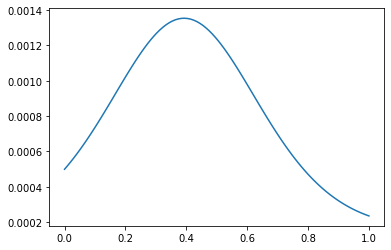

In [85]:
plt.plot(t, b)

Check that we get 1:

In [86]:
1 - ls_qr(A, b)[14]

-4.362977377159183e-07

Bad condition number:

In [87]:
kappa = np.linalg.cond(A); kappa

22717777974.94562

In [88]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [89]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [92]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.loc[name, 'Time'] = t #df.set_value(name, 'Time', t)
    df.loc[name, 'Error'] = np.abs(1 - coeffs[-1]) #df.set_value(name, 'Error', np.abs(1 - coeffs[-1]))

In [93]:
df

,Time,Error
Normal Eqns- Naive,0.008243500,1.546394689
QR Factorization,0.005005000,0.000000436
SVD,0.004724300,0.000000436
Scipy lstsq,0.004662000,0.000000436



The solution for least squares via the normal equations is unstable in general, although stable for problems with small condition numbers.

### Low-rank

In [94]:
m = 100
n = 10
x = np.random.uniform(-10,10,n)
A2 = np.random.uniform(-40,40, [m, int(n/2)])   # removed np.asfortranarray
A = np.hstack([A2, A2])

In [95]:
A.shape, A2.shape

((100, 10), (100, 5))

In [96]:
b = A @ x + np.random.normal(0,1,m)

In [97]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [98]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [100]:
df.corr()

""


In [ ]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.loc[name, 'Time'] = t #df.set_value(name, 'Time', t)
    df.loc[name, 'Error'] = regr_metrics(b, A @ coeffs)[0] #df.set_value(name, 'Error', regr_metrics(b, A @ coeffs)[0])

In [ ]:
df

## Comparison

Our results from above:

In [ ]:
df

From Trefethen (page 84):

Normal equations/Cholesky is fastest when it works.  Cholesky can only be used on symmetric, positive definite matrices.  Also, normal equations/Cholesky is unstable for matrices with high condition numbers or with low-rank.

Linear regression via QR has been recommended by numerical analysts as the standard method for years.  It is natural, elegant, and good for "daily use".